# Relatório Parcial

Supercomputação - Cicero Tiago

Arquivos Relevantes:

- `tools.py`
- `results.json`
- `entradas/*`

### Entregáveis

- **Código-fonte da implementação sequencial e da implementação paralela**:\
  Todo o código fonte da implementação está contido nas pastas numeradas;

- **Arquivos de testes utilizados**:\
  Os arquivos de testes utilizados estão contidos na pasta `entradas/`;

## Escolha do algoritmo a ser paralelizado

A escolha do algoritmo a ser refatorado com a utilização da biblioteca OpenMP levou em consideração principalmente 2 fatores:

- Quantidade de loops iterações independentes;
- Quantidade de trechos necessariamente sequenciais;

Com isso, o algoritmo escolhido foi o de busca exaustiva, pois executa muitas repetições paralelizáveis e demanda muito _tempo de cpu_.

Além disso, um terceiro fator que se mostrou relevante foi que a tentativa de paralelizar alguns loops parecia trazer um _overhead_ que aumentava o tempo de processamento ao invés de diminuir.

In [9]:
# -*- encoding :: UTF-8 -*-

import os
import matplotlib.pyplot as plt
import numpy as np
import json
from tools import Result, generate_input, get_executables, get_input_files, get_input_size, run_executable
import json

In [10]:
def get_executables(folders=[], executable_name=['parallel', 'sequential']):
    executables = []
    for exec_name in executable_name:
        executables += [os.path.join(folder, exec_name) for folder in folders]
    executables.sort()
    return executables

### Gerando os arquivos de entrada

In [ ]:
def generate_input_files():
    """Gera arquivos de entrada em lote"""
    # todos os valores de 1 a 50
    for i in range(1, 50):
        generate_input(i, i)

    # pares de 50 a 60
    for i in range(50, 61, 2):
        generate_input(i, i)

    # multiplos de 3 de 60 a 70
    for i in range(61, 70, 3):
        generate_input(i, i)
    
    # multiplos de 10 de 70 a 100
    for i in range(70, 101, 10):
        generate_input(i, i) 

# generate_input_files()

In [51]:
def process():
    input_files = get_input_files('entradas')

    # project_folders = ['01-heuristica', '02-busca-local', '03-busca-exaustiva']
    project_folders = ["04-openmp"]

    # lista de arquivos executáveis
    executables = get_executables(project_folders)

    results = []

    # executa todos os arquivos de entrada em todos os algoritmos
    for exe in executables:
        for input_file in input_files:
            input_size = get_input_size(input_file)
            proc, execution_time = run_executable(exe, input_file)
            result_name = os.path.basename(exe)
            result = Result(result_name, input_size, execution_time)
            results.append(result)
            print(result)

    # formata e salva os um JSON com resultados
    groups = {}
    for result in results:
        group_name = result.executable
        if group_name not in groups:
            groups[group_name] = []
        item = {"input_size": result.input_size, "exec_time": result.exec_time}
        groups[group_name].append(item)

    with open("04-results.json", 'w+', encoding='utf-8') as output_file:
        output_file.write(json.dumps(groups))

# Leva cerca de 35 minutos pra rodar
# process()

Carrega o arquivo de resultados

In [20]:
with open("04-results.json", 'r', encoding='utf-8') as results_file:
    results = json.loads(results_file.read())

Formata de modo conveniente para plotar

In [48]:
groups = {}
for group_name, values in results.items():
    groups[group_name] = np.array( [ [ item['input_size'], item['exec_time'] ] for item in values ] )

Plotagem de (tamanho de entrada)x(tempo de execução)

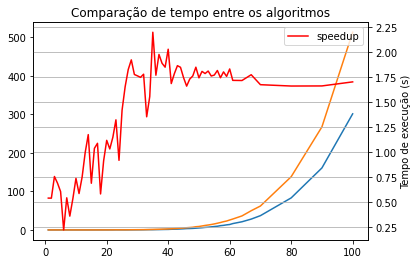

In [52]:
ax1 = plt.subplot()
ax2 = ax1.twinx()

for group, array in groups.items():
    ax1.plot(array[:, 0], array[:, 1], label=group)

speedup =  groups["sequential"][:, 1] / groups["parallel"][:, 1]

ax2.plot(array[:, 0], speedup, label="speedup", color='red')


plt.title("Comparação de tempo entre os algoritmos")
plt.xlabel("Tamanho das entradas")
plt.ylabel("Tempo de execução (s)")
plt.legend()
plt.grid()
plt.show()


---

Para analisar os scripts compilados, foi utilizada a ferramenta de profiling ***valgrind*** conforme o exemplo abaixo, mas o resultado obtido não foi muito esclarecedor a não ser pelo alto número de operações (ordem de bilhões para o algoritmo de busca exaustiva).

```shell
# exemplo
$ valgrind --tool=callgrind ./03-busca-exaustiva/script < entradas/0030x0030.seq
$ callgrind_annotate ./03-busca-exaustiva/callgrind.out.68337 ./03-busca-exaustiva/main.cpp
```

#### Considerações sobre os scripts

Em geral, os scripts desenvolvidos utilizam muitos loops e alguns deles são desnecessários ou realizam tarefas como preparara a saída do programa.

**01 - Heurística de Alinhamento Smith-Waterman**

--

**02 - Busca Local (Aleatorização)**

O código desse algoritmo utiliza uma versão um pouco mais limpa do anterior (descarta chamadas de `std::cout` desnecessárias para a comparação), mas certamente devolve um resultado de qualidade inferior _by design_. Isso poderia ser melhorado se ele fosse executado várias vezes e o melhor dos resultados fosse escolhido.

**03 - Busca Exaustiva**

De longe é, dentre os 3, o que mais realiza operações, pois gera todas as subsequêcias possíveis para cada uma das sequências grandes e utiliza 2 métodos diferentes para comparar cada par de subsquências geradas.

